<h1>CO<sub>2</sub> Emission Prediction of Sri Lanka using LSTM (Univariate)</h1>
<p>LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) architecture designed to efficiently capture and utilize long-term dependencies in <b>sequential data</b>. In this project, I will be developping an LSTM model to predict future CO<sub>2</sub> emission.</p>

<p>CO<sub>2</sub> emission data is a <b>Timeseries</b> dataset, which fits for sequential model perfectly.</p>

## Dataset
<p>I will be using CO<sub>2</sub> emission data set by country from <a href="https://www.kaggle.com/datasets/ulrikthygepedersen/co2-emissions-by-country" target="_blank">Kaggle</a></p>

<div class="alert alert-success">
    <h3>Table of content</h3>
    <ol>
        <li>
            <a href="#Technologies and tools">Technologies and tools</a>
        </li>
        <li><a href="#Load-Dataset">Load Dataset</a></li>
        <li><a href="#check_dimensions">Check dimensions of Data</a></li>
        <li><a href="#forward_prop">Implementing Forward Propagation</a></li>
        <li><a href="#compile_model">Compile the model</a></li>
        <li><a href="#summary_of_the_model">Summary of the model</a></li>
        <li><a href="#train_and_evaluation">Train and evaluation</a></li>
        <li><a href="#save_model">Save the model</a></li>
    </ol>
</div>

## Technologies and tools
1. TensorFlow
2. Keras
3. LSTM
4. Sequential Model

## Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import pickle
%matplotlib inline

In [82]:
df_full = pd.read_csv('co2_emissions_kt_by_country.csv')

In [83]:
df_full.head()

,country_code,country_name,year,value
0,ABW,Aruba,1960,11092.675
1,ABW,Aruba,1961,11576.719
2,ABW,Aruba,1962,12713.489
3,ABW,Aruba,1963,12178.107
4,ABW,Aruba,1964,11840.743


In [84]:
df_full['country_name'].unique()

array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Bahamas, The', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bermuda', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Chile', 'China',
       "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria',
       'East Asia & Pacific (excluding

In [85]:
df = df_full[df_full['country_name']=='Sri Lanka']

## Data celanup

### Remove unwanted columns

In [86]:
df.head()

,country_code,country_name,year,value
7399,LKA,Sri Lanka,1960,2258.872
7400,LKA,Sri Lanka,1961,2335.879
7401,LKA,Sri Lanka,1962,2563.233
7402,LKA,Sri Lanka,1963,2533.897
7403,LKA,Sri Lanka,1964,2273.540


In [87]:
df.drop(['country_code', 'country_name'], axis=1, inplace=True)

C:\Users\navilog\AppData\Local\Temp\ipykernel_2992\3515826104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['country_code', 'country_name'], axis=1, inplace=True)


In [88]:
df.reset_index(drop=True, inplace=True)

In [89]:
df.head()

,year,value
0,1960,2258.872
1,1961,2335.879
2,1962,2563.233
3,1963,2533.897
4,1964,2273.540


In [90]:
df_year = df['year']
df_year

0     1960
1     1961
2     1962
3     1963
4     1964
5     1965
6     1966
7     1967
8     1968
9     1969
10    1970
11    1971
12    1972
13    1973
14    1974
15    1975
16    1976
17    1977
18    1978
19    1979
20    1980
21    1981
22    1982
23    1983
24    1984
25    1985
26    1986
27    1987
28    1988
29    1989
30    1990
31    1991
32    1992
33    1993
34    1994
35    1995
36    1996
37    1997
38    1998
39    1999
40    2000
41    2001
42    2002
43    2003
44    2004
45    2005
46    2006
47    2007
48    2008
49    2009
50    2010
51    2011
52    2012
53    2013
54    2014
55    2015
56    2016
57    2017
58    2018
59    2019
Name: year, dtype: int64

### check for null values

In [91]:
df.isna().sum()

year     0
value    0
dtype: int64

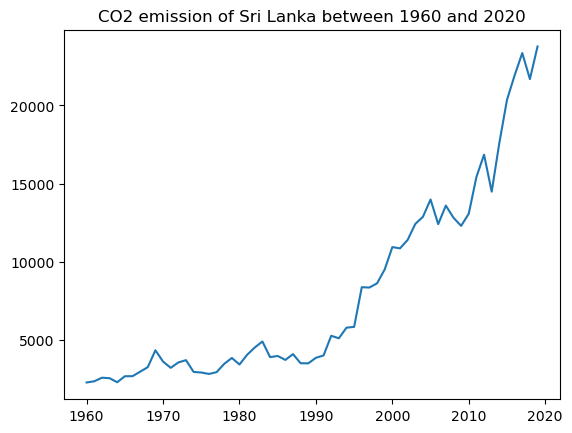

In [92]:
plt.plot(df['year'], df['value'])
plt.title('CO2 emission of Sri Lanka between 1960 and 2020')
plt.show()

<div class="alert alert-info">
    <h3>Observations:</h3>
    <ol>
        <li>Between 1960 and mid 90s the carbon emission was not much increased.</li>
        <li>After that, it has increased rapidly.</li>
    </ol>
</div>

## Data Preprocessing
In the data preprocessing stage I will be performing following things.
- filter the CO2 emission value column from the dataset
- rearrange the CO2 emission values and prepare a supervised learning dataset.
- reshape prepared dataset for LSTM model

In [93]:
df_co2 = df['value']
#df_co2

In [94]:
df_co2.describe()

count       60.000000
mean      7945.101660
std       6161.212232
min       2258.872000
25%       3440.562750
50%       4409.567500
75%      12402.499676
max      23780.000687
Name: value, dtype: float64

Above descriptive statistics shows that min and max values quite apart each other. Deep Learning prefers scaled data.
## Data scaling
In the dataset we have all positive values. I will use **Min-Max** scaler in the range of 0 and 1.

In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df_co2).reshape(-1, 1))

<IPython.core.display.Javascript object>

## Save scaler and original emission values for future use

In [96]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [97]:
df[['year', 'value']].to_csv('year_emission.csv', index=False)

### Split dataset into train / validation sets

In [98]:
train_size = int(len(df_scaled) * 0.70)
val_size = len(df_scaled) - train_size

train_size, val_size

(42, 18)

In [99]:
train_data, val_data = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :1]
train_data.shape, val_data.shape

((42, 1), (18, 1))

In [100]:
train_data_year, val_data_year = df_year[0:train_size], df_year[train_size:len(df_year)]
train_data_year.shape, val_data_year.shape

((42,), (18,))

### Prepare data for LSTM modelling
- In sequential models we assume that, the output at some timestep is dependent on it's previous values.
- So, here we will prepare a **supervised learning** dataset by taking 5 values as inputs and 6th value as the output. (window_size = 6) 
- Then we repeat the process by shifting the values one by one to generate the new supervides learning dataset for LSTM.

In [101]:
def create_dataset(dataset, window_size=1):
    """
    Prepare supervised learning dataset from time series data for LSTM model.
    
    Arguments:
    dataset -- Pandas Array: Time series values for prepreocessing
    window_size -- Integer: How many time steps as inputs of the resulting supervised learning dataset.
    
    Return:
    Tuple object containing data for inputs and outputs
    """
    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
        
    return np.array(dataX), np.array(dataY)       
        

In [102]:
window_size = 2
X_train, y_train = create_dataset(train_data, window_size)
X_val, y_val = create_dataset(val_data, window_size)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((39, 2), (39,), (15, 2), (15,))

### Reshape train and validation sets for LSTM
- For LSTM, we need to reshape out data as 3D matrix. - *(samples, window_size, features/variables)*
- In this project we do univariate LSTM model. So, the last dimension will be 1

In [104]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [105]:
X_train.shape

(39, 2, 1)

## Prepare LSTM model

In [106]:
model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and fit the model
I use following configurations to fit the model
- **Adam** optimizer with learning rate 0.001
- Save the best model instance as checkpoint separately.

In [107]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
optimizer = Adam(learning_rate=0.0001)
model.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=[RootMeanSquaredError()])

In [108]:
model.fit(X_train, y_train, verbose=1, validation_data=(X_val, y_val), epochs=200, callbacks=[cp1])

Epoch 1/200
1/2 [==============>...............] - ETA: 1s - loss: 0.0168 - root_mean_squared_error: 0.1298INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 5s 3s/step - loss: 0.0193 - root_mean_squared_error: 0.1391 - val_loss: 0.4627 - val_root_mean_squared_error: 0.6802
Epoch 2/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.1258INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0188 - root_mean_squared_error: 0.1372 - val_loss: 0.4579 - val_root_mean_squared_error: 0.6766
Epoch 3/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.1264INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0184 - root_mean_squared_error: 0.1355 - val_loss: 0.4530 - val_root_mean_squared_error: 0.6730
Epoch 4/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.1330INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0179 - root_mean_squared_error: 0.1340 - val_loss: 0.4482 - val_root_mean_squared_error: 0.6695
Epoch 5/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1110INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.4436 - val_root_mean_squared_error: 0.6660
Epoch 6/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1305INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.4391 - val_root_mean_squared_error: 0.6627
Epoch 7/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1308INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 2s/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.4349 - val_root_mean_squared_error: 0.6595
Epoch 8/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.1403INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.4309 - val_root_mean_squared_error: 0.6565
Epoch 9/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1309INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.4271 - val_root_mean_squared_error: 0.6536
Epoch 10/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1280INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.4234 - val_root_mean_squared_error: 0.6507
Epoch 11/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1360INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.4198 - val_root_mean_squared_error: 0.6479
Epoch 12/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0157 - root_mean_squared_error: 0.1253INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0153 - root_mean_squared_error: 0.1239 - val_loss: 0.4163 - val_root_mean_squared_error: 0.6452
Epoch 13/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1109INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0151 - root_mean_squared_error: 0.1227 - val_loss: 0.4129 - val_root_mean_squared_error: 0.6426
Epoch 14/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.1311INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.4095 - val_root_mean_squared_error: 0.6399
Epoch 15/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.1114INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.4062 - val_root_mean_squared_error: 0.6373
Epoch 16/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.1215INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.4029 - val_root_mean_squared_error: 0.6347
Epoch 17/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1268INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.3997 - val_root_mean_squared_error: 0.6322
Epoch 18/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.1264INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.3966 - val_root_mean_squared_error: 0.6298
Epoch 19/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1179INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.3937 - val_root_mean_squared_error: 0.6274
Epoch 20/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.1071INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.3907 - val_root_mean_squared_error: 0.6250
Epoch 21/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1247INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.3876 - val_root_mean_squared_error: 0.6226
Epoch 22/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1015INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.3847 - val_root_mean_squared_error: 0.6202
Epoch 23/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.1218INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.3816 - val_root_mean_squared_error: 0.6178
Epoch 24/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.1215INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.3787 - val_root_mean_squared_error: 0.6154
Epoch 25/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1101INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.3759 - val_root_mean_squared_error: 0.6131
Epoch 26/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.1080INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.3730 - val_root_mean_squared_error: 0.6107
Epoch 27/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1178INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.3701 - val_root_mean_squared_error: 0.6083
Epoch 28/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1155INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.3672 - val_root_mean_squared_error: 0.6060
Epoch 29/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1087INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0111 - root_mean_squared_error: 0.1054 - val_loss: 0.3643 - val_root_mean_squared_error: 0.6036
Epoch 30/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1052INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.3613 - val_root_mean_squared_error: 0.6011
Epoch 31/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0865INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.3581 - val_root_mean_squared_error: 0.5984
Epoch 32/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0932INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.3545 - val_root_mean_squared_error: 0.5954
Epoch 33/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0990INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.3508 - val_root_mean_squared_error: 0.5923
Epoch 34/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1092INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.3471 - val_root_mean_squared_error: 0.5892
Epoch 35/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1011INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.3435 - val_root_mean_squared_error: 0.5861
Epoch 36/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0978INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.3399 - val_root_mean_squared_error: 0.5830
Epoch 37/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0882INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.3363 - val_root_mean_squared_error: 0.5799
Epoch 38/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1054INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.3326 - val_root_mean_squared_error: 0.5767
Epoch 39/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0884INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.3291 - val_root_mean_squared_error: 0.5737
Epoch 40/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1033INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.3257 - val_root_mean_squared_error: 0.5707
Epoch 41/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0612INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.3224 - val_root_mean_squared_error: 0.5678
Epoch 42/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0992INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.3189 - val_root_mean_squared_error: 0.5647
Epoch 43/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.0998INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.3156 - val_root_mean_squared_error: 0.5618
Epoch 44/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0980INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.3126 - val_root_mean_squared_error: 0.5591
Epoch 45/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0993INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.3098 - val_root_mean_squared_error: 0.5566
Epoch 46/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0805INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.3071 - val_root_mean_squared_error: 0.5541
Epoch 47/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0924INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.3043 - val_root_mean_squared_error: 0.5516
Epoch 48/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0902INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.3016 - val_root_mean_squared_error: 0.5492
Epoch 49/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0864INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.2988 - val_root_mean_squared_error: 0.5466
Epoch 50/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - root_mean_squared_error: 0.0949INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.2961 - val_root_mean_squared_error: 0.5441
Epoch 51/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0783INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.2933 - val_root_mean_squared_error: 0.5416
Epoch 52/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0873INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.2904 - val_root_mean_squared_error: 0.5389
Epoch 53/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0827INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.2874 - val_root_mean_squared_error: 0.5361
Epoch 54/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0778INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.2843 - val_root_mean_squared_error: 0.5332
Epoch 55/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0918INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.2812 - val_root_mean_squared_error: 0.5303
Epoch 56/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0917INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.2784 - val_root_mean_squared_error: 0.5276
Epoch 57/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0083 - root_mean_squared_error: 0.0912INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.2758 - val_root_mean_squared_error: 0.5252
Epoch 58/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0843INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.2734 - val_root_mean_squared_error: 0.5228
Epoch 59/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0819INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.2708 - val_root_mean_squared_error: 0.5204
Epoch 60/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.2683 - val_root_mean_squared_error: 0.5180
Epoch 61/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0840INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.2661 - val_root_mean_squared_error: 0.5158
Epoch 62/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0737INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.2637 - val_root_mean_squared_error: 0.5135
Epoch 63/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0640INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.2609 - val_root_mean_squared_error: 0.5108
Epoch 64/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0799INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.2578 - val_root_mean_squared_error: 0.5078
Epoch 65/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0862INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.2550 - val_root_mean_squared_error: 0.5050
Epoch 66/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0858INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.2526 - val_root_mean_squared_error: 0.5026
Epoch 67/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.0858INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.2505 - val_root_mean_squared_error: 0.5005
Epoch 68/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0770INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.2484 - val_root_mean_squared_error: 0.4984
Epoch 69/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0659INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.2462 - val_root_mean_squared_error: 0.4962
Epoch 70/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0851INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.2438 - val_root_mean_squared_error: 0.4937
Epoch 71/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0703INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.2415 - val_root_mean_squared_error: 0.4914
Epoch 72/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0799INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.2392 - val_root_mean_squared_error: 0.4890
Epoch 73/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0822INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.2370 - val_root_mean_squared_error: 0.4869
Epoch 74/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0783INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.2351 - val_root_mean_squared_error: 0.4848
Epoch 75/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0633INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.2328 - val_root_mean_squared_error: 0.4825
Epoch 76/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0621INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.2302 - val_root_mean_squared_error: 0.4798
Epoch 77/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0771INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.2275 - val_root_mean_squared_error: 0.4770
Epoch 78/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0763INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.2250 - val_root_mean_squared_error: 0.4743
Epoch 79/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0756INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.2226 - val_root_mean_squared_error: 0.4718
Epoch 80/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0748INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.2204 - val_root_mean_squared_error: 0.4695
Epoch 81/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0724INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.2182 - val_root_mean_squared_error: 0.4671
Epoch 82/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0792INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.2161 - val_root_mean_squared_error: 0.4649
Epoch 83/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0566INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.2140 - val_root_mean_squared_error: 0.4626
Epoch 84/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0773INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0051 - root_mean_squared_error: 0.0718 - val_loss: 0.2116 - val_root_mean_squared_error: 0.4600
Epoch 85/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0734INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.2096 - val_root_mean_squared_error: 0.4578
Epoch 86/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0642INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.2075 - val_root_mean_squared_error: 0.4555
Epoch 87/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0709INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.2053 - val_root_mean_squared_error: 0.4531
Epoch 88/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0755INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.2032 - val_root_mean_squared_error: 0.4508
Epoch 89/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0634INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.2011 - val_root_mean_squared_error: 0.4485
Epoch 90/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0756INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - val_loss: 0.1989 - val_root_mean_squared_error: 0.4460
Epoch 91/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0713INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0048 - root_mean_squared_error: 0.0689 - val_loss: 0.1968 - val_root_mean_squared_error: 0.4436
Epoch 92/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0614INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.1947 - val_root_mean_squared_error: 0.4412
Epoch 93/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0676INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0046 - root_mean_squared_error: 0.0682 - val_loss: 0.1925 - val_root_mean_squared_error: 0.4388
Epoch 94/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0692INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.1905 - val_root_mean_squared_error: 0.4365
Epoch 95/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0728INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.1886 - val_root_mean_squared_error: 0.4343
Epoch 96/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0721INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.1869 - val_root_mean_squared_error: 0.4323
Epoch 97/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0714INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.1854 - val_root_mean_squared_error: 0.4306
Epoch 98/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0709INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - val_loss: 0.1841 - val_root_mean_squared_error: 0.4290
Epoch 99/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0706INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4277
Epoch 100/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0675INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 101/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0555INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.1802 - val_root_mean_squared_error: 0.4246
Epoch 102/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0587INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.1781 - val_root_mean_squared_error: 0.4221
Epoch 103/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0580INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.1756 - val_root_mean_squared_error: 0.4191
Epoch 104/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0692INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.1731 - val_root_mean_squared_error: 0.4160
Epoch 105/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0651INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.1708 - val_root_mean_squared_error: 0.4133
Epoch 106/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0441INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.1683 - val_root_mean_squared_error: 0.4103
Epoch 107/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0638INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.1656 - val_root_mean_squared_error: 0.4069
Epoch 108/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0676INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.1632 - val_root_mean_squared_error: 0.4040
Epoch 109/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0665INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.1612 - val_root_mean_squared_error: 0.4015
Epoch 110/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0594INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.1594 - val_root_mean_squared_error: 0.3992
Epoch 111/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0610INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.1576 - val_root_mean_squared_error: 0.3969
Epoch 112/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0611INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.1557 - val_root_mean_squared_error: 0.3946
Epoch 113/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0549INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.1539 - val_root_mean_squared_error: 0.3923
Epoch 114/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0579INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.1520 - val_root_mean_squared_error: 0.3898
Epoch 115/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0584INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.1501 - val_root_mean_squared_error: 0.3875
Epoch 116/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0532INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.1481 - val_root_mean_squared_error: 0.3849
Epoch 117/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0463INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 2s 2s/step - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.1457 - val_root_mean_squared_error: 0.3817
Epoch 118/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0578INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.1431 - val_root_mean_squared_error: 0.3783
Epoch 119/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0523INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.1406 - val_root_mean_squared_error: 0.3749
Epoch 120/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0560INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.1380 - val_root_mean_squared_error: 0.3715
Epoch 121/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0604INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.1359 - val_root_mean_squared_error: 0.3686
Epoch 122/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0451INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.1339 - val_root_mean_squared_error: 0.3660
Epoch 123/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0534INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.1319 - val_root_mean_squared_error: 0.3632
Epoch 124/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0584INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 5s 5s/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.1302 - val_root_mean_squared_error: 0.3608
Epoch 125/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0510INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.1288 - val_root_mean_squared_error: 0.3589
Epoch 126/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0579INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0029 - root_mean_squared_error: 0.0537 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3573
Epoch 127/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0456INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.1263 - val_root_mean_squared_error: 0.3554
Epoch 128/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0567INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.1246 - val_root_mean_squared_error: 0.3530
Epoch 129/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3508
Epoch 130/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0506INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3484
Epoch 131/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457
Epoch 132/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0534INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.1174 - val_root_mean_squared_error: 0.3426
Epoch 133/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0535INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3399
Epoch 134/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0497INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3374
Epoch 135/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0530INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.1123 - val_root_mean_squared_error: 0.3352
Epoch 136/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0491INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.1108 - val_root_mean_squared_error: 0.3329
Epoch 137/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0520INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.1092 - val_root_mean_squared_error: 0.3304
Epoch 138/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0502INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.1078 - val_root_mean_squared_error: 0.3283
Epoch 139/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0503INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.1064 - val_root_mean_squared_error: 0.3263
Epoch 140/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0500INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.1052 - val_root_mean_squared_error: 0.3244
Epoch 141/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0478INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.1038 - val_root_mean_squared_error: 0.3222
Epoch 142/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0496INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.1023 - val_root_mean_squared_error: 0.3199
Epoch 143/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0427INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.1008 - val_root_mean_squared_error: 0.3175
Epoch 144/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0399INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 145/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0969 - val_root_mean_squared_error: 0.3112
Epoch 146/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0459INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3080
Epoch 147/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0386INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0931 - val_root_mean_squared_error: 0.3052
Epoch 148/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0466INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 149/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0469INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0900 - val_root_mean_squared_error: 0.3000
Epoch 150/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0453INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0889 - val_root_mean_squared_error: 0.2981
Epoch 151/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2965
Epoch 152/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0440INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0870 - val_root_mean_squared_error: 0.2950
Epoch 153/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0431INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0859 - val_root_mean_squared_error: 0.2931
Epoch 154/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0445INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0846 - val_root_mean_squared_error: 0.2909
Epoch 155/200
1/2 [==============>...............] - ETA: 0s - loss: 7.3897e-04 - root_mean_squared_error: 0.0272INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0830 - val_root_mean_squared_error: 0.2882
Epoch 156/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0811 - val_root_mean_squared_error: 0.2848
Epoch 157/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0428INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0795 - val_root_mean_squared_error: 0.2819
Epoch 158/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0370INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0780 - val_root_mean_squared_error: 0.2792
Epoch 159/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2765
Epoch 160/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0343INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2738
Epoch 161/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0735 - val_root_mean_squared_error: 0.2712
Epoch 162/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0353INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0723 - val_root_mean_squared_error: 0.2689
Epoch 163/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0358INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0712 - val_root_mean_squared_error: 0.2668
Epoch 164/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0392INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0700 - val_root_mean_squared_error: 0.2645
Epoch 165/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0396INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 166/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0386INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2605
Epoch 167/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0336INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2588
Epoch 168/200
1/2 [==============>...............] - ETA: 0s - loss: 8.4279e-04 - root_mean_squared_error: 0.0290INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2564
Epoch 169/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0387INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0644 - val_root_mean_squared_error: 0.2538
Epoch 170/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0339INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2516
Epoch 171/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0371INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0623 - val_root_mean_squared_error: 0.2495
Epoch 172/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0363INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2480
Epoch 173/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0341INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2462
Epoch 174/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0330INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2439
Epoch 175/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0323INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 176/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0362INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0571 - val_root_mean_squared_error: 0.2389
Epoch 177/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0332INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0559 - val_root_mean_squared_error: 0.2364
Epoch 178/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0340INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2337
Epoch 179/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0335INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2314
Epoch 180/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0358INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2295
Epoch 181/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0337INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2280
Epoch 182/200
1/2 [==============>...............] - ETA: 0s - loss: 7.6608e-04 - root_mean_squared_error: 0.0277INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0513 - val_root_mean_squared_error: 0.2265
Epoch 183/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0319INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247
Epoch 184/200
1/2 [==============>...............] - ETA: 0s - loss: 8.6542e-04 - root_mean_squared_error: 0.0294INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0496 - val_root_mean_squared_error: 0.2227
Epoch 185/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0339INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2209
Epoch 186/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0335INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2192
Epoch 187/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0336INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2176
Epoch 188/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0344INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2161
Epoch 189/200
1/2 [==============>...............] - ETA: 0s - loss: 8.1033e-04 - root_mean_squared_error: 0.0285INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2144
Epoch 190/200
1/2 [==============>...............] - ETA: 0s - loss: 8.0846e-04 - root_mean_squared_error: 0.0284INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2122
Epoch 191/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0329INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 9.9835e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2099
Epoch 192/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0336INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 9.9935e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2079
Epoch 193/200
1/2 [==============>...............] - ETA: 0s - loss: 7.8585e-04 - root_mean_squared_error: 0.0280INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0425 - val_root_mean_squared_error: 0.2061
Epoch 194/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0329INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2048
Epoch 195/200
1/2 [==============>...............] - ETA: 0s - loss: 8.0289e-04 - root_mean_squared_error: 0.0283INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2039
Epoch 196/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0319INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 9.8519e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 197/200
1/2 [==============>...............] - ETA: 0s - loss: 8.0097e-04 - root_mean_squared_error: 0.0283INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 9.7817e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 198/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0329INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 9.5484e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2023
Epoch 199/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0323INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 4s 4s/step - loss: 9.5125e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 200/200
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0331INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


2/2 [==============================] - 3s 3s/step - loss: 9.4181e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0402 - val_root_mean_squared_error: 0.2005


### Load the model checkpoints and predict

In [109]:
best_model = load_model('model/')

In [110]:
train_predict = best_model.predict(X_train)
train_predict = scaler.inverse_transform(train_predict)
train_predict

2/2 [==============================] - 0s 3ms/step


array([[2609.369 ],
       [2727.106 ],
       [2808.241 ],
       [2696.7927],
       [2738.2483],
       [2898.7842],
       [3015.1975],
       [3315.3792],
       [4044.0576],
       [4258.005 ],
       [3649.1084],
       [3610.3926],
       [3877.3293],
       [3560.8508],
       [3130.842 ],
       [3066.4312],
       [3075.0005],
       [3409.034 ],
       [3900.2083],
       [3888.2505],
       [3986.1885],
       [4576.2085],
       [5037.962 ],
       [4721.5493],
       [4206.5005],
       [4113.566 ],
       [4169.2285],
       [4066.2607],
       [3740.9697],
       [3924.53  ],
       [4200.1377],
       [4949.445 ],
       [5564.007 ],
       [5836.61  ],
       [6242.449 ],
       [7630.8584],
       [8971.283 ],
       [9069.728 ],
       [9401.932 ]], dtype=float32)

In [111]:
train_predict.flatten()

array([2609.369 , 2727.106 , 2808.241 , 2696.7927, 2738.2483, 2898.7842,
       3015.1975, 3315.3792, 4044.0576, 4258.005 , 3649.1084, 3610.3926,
       3877.3293, 3560.8508, 3130.842 , 3066.4312, 3075.0005, 3409.034 ,
       3900.2083, 3888.2505, 3986.1885, 4576.2085, 5037.962 , 4721.5493,
       4206.5005, 4113.566 , 4169.2285, 4066.2607, 3740.9697, 3924.53  ,
       4200.1377, 4949.445 , 5564.007 , 5836.61  , 6242.449 , 7630.8584,
       8971.283 , 9069.728 , 9401.932 ], dtype=float32)

Text(0.5, 1.0, 'Training Accuracy')

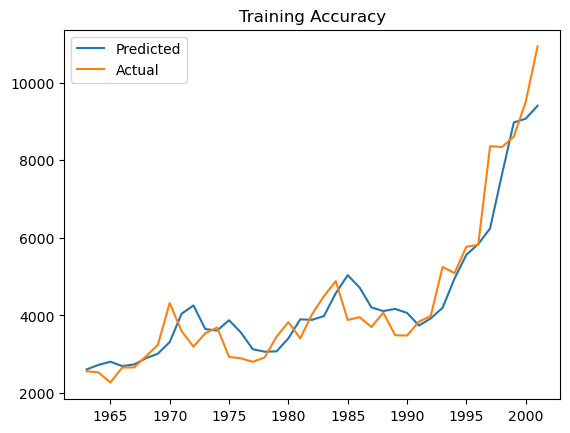

In [112]:
plt.plot(train_data_year[window_size+1:], train_predict.flatten())
plt.plot(train_data_year[window_size+1:], scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.legend(['Predicted', 'Actual'])
plt.title('Training Accuracy')

In [113]:
val_predict = best_model.predict(X_val)
val_predict = scaler.inverse_transform(val_predict)
val_predict

1/1 [==============================] - 0s 21ms/step


array([[10899.3125],
       [11299.564 ],
       [11683.564 ],
       [11644.606 ],
       [11459.824 ],
       [11625.26  ],
       [11282.571 ],
       [11310.394 ],
       [12068.114 ],
       [13077.589 ],
       [12950.0625],
       [12974.496 ],
       [14523.23  ],
       [15697.303 ],
       [16491.459 ]], dtype=float32)

Text(0.5, 1.0, 'Validation Accuracy')

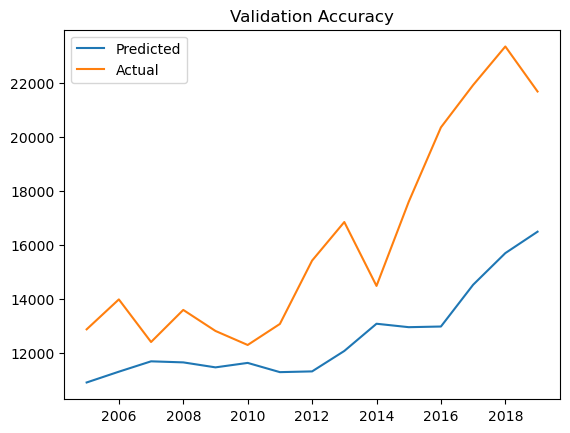

In [114]:
plt.plot(val_data_year[window_size+1:], val_predict.flatten())
plt.plot(val_data_year[window_size+1:], scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.legend(['Predicted', 'Actual'])
plt.title('Validation Accuracy')

<h2>CO<sub>2</sub> prediction for next 5 years</h2>
In order to predict next 10 years, we have to start with last 5 (window_size) records of the dataset and predict future values one by one.

In [115]:
val_data

array([[0.42428668],
       [0.47168195],
       [0.49305629],
       [0.5446335 ],
       [0.47121728],
       [0.5265118 ],
       [0.49026836],
       [0.46610604],
       [0.50234947],
       [0.61154451],
       [0.67799085],
       [0.56786648],
       [0.71284033],
       [0.8410864 ],
       [0.91403795],
       [0.98048429],
       [0.90288613],
       [1.        ]])

In [116]:
val_data.shape

(18, 1)

In [117]:
x_input = val_data[-(window_size):].reshape(1, -1)
x_input.shape

(1, 2)

In [118]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [119]:
temp_input

[0.9028861272557324, 1.0]

In [120]:
from numpy import array

lst_output=[]
n_steps=window_size
number_of_years_to_predict = 5
i=0
while(i<number_of_years_to_predict):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} Year input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} Year output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.662503]
3


<IPython.core.display.Javascript object>

1 Year input [1.       0.662503]
1 Year output [[0.61310893]]


<IPython.core.display.Javascript object>

2 Year input [0.662503   0.61310893]
2 Year output [[0.5026447]]


<IPython.core.display.Javascript object>

3 Year input [0.61310893 0.50264472]
3 Year output [[0.4630377]]


<IPython.core.display.Javascript object>

4 Year input [0.50264472 0.4630377 ]
4 Year output [[0.42217112]]
[[0.6625030040740967], [0.6131089329719543], [0.5026447176933289], [0.4630376994609833], [0.42217111587524414]]


### Plot predicted values

In [121]:
year_new = val_data_year[-window_size:] # new year range
year_pred = np.arange(int(year_new[-1:]) + 1, int(year_new[-1:]) + number_of_years_to_predict + 1) # new predicted years

<IPython.core.display.Javascript object>

In [122]:
original_data_from_df = scaler.inverse_transform(df_scaled[(len(df_co2) - window_size):])
original_data_from_predicteds = scaler.inverse_transform(lst_output)

In [123]:
original_data_from_df

array([[21690.00053406],
       [23780.00068665]])

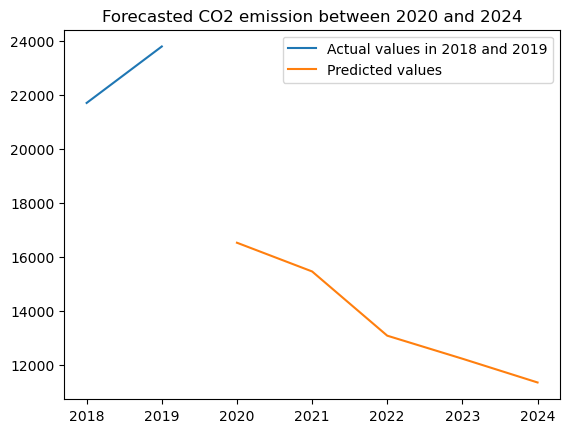

In [124]:
plt.title('Forecasted CO2 emission between 2020 and 2024')
plt.plot(year_new, original_data_from_df)
plt.plot(year_pred, original_data_from_predicteds)
plt.legend(['Actual values in 2018 and 2019', 'Predicted values'])
plt.show()

### Combine predicteds to the original dataset and plot

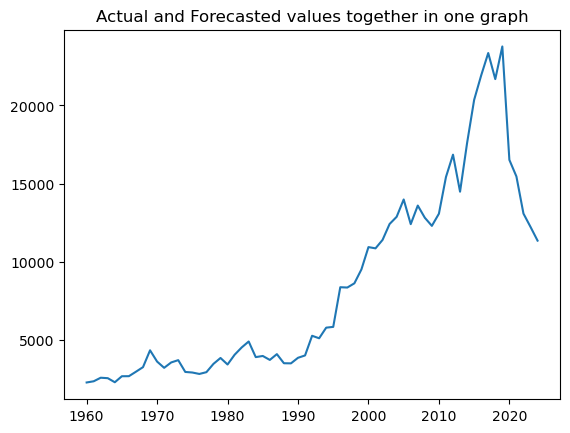

In [125]:
df3 = scaler.inverse_transform(df_scaled).tolist()
df3.extend(scaler.inverse_transform((lst_output)))
df3_year = list(df_year) + list(year_pred)

plt.title('Actual and Forecasted values together in one graph')
plt.plot(df3_year, df3)
plt.show()